In [1]:
import numpy as np

In [2]:
input = """p=0,4 v=3,-3
p=6,3 v=-1,-3
p=10,3 v=-1,2
p=2,0 v=2,-1
p=0,0 v=1,3
p=3,0 v=-2,-2
p=7,6 v=-1,-3
p=3,0 v=-1,-2
p=9,3 v=2,3
p=7,3 v=-1,2
p=2,4 v=2,-3
p=9,5 v=-3,-3"""
# dims = np.array([11, 7])  # note: all primes

input = open("inputs/14").read()
dims = np.array([101, 103])  # note: all primes


def parse_input(input_str):
    robots = []
    for line in input_str.strip().split("\n"):
        # Split into position and velocity parts
        pos_part, vel_part = line.split(" v=")

        # Parse position
        pos_x, pos_y = map(int, pos_part.replace("p=", "").split(","))

        # Parse velocity
        vel_x, vel_y = map(int, vel_part.split(","))

        robots.append(((pos_x, pos_y), (vel_x, vel_y)))
    return robots


robots = parse_input(input)


In [3]:
robots

[((81, 85), (-35, 88)),
 ((89, 76), (-33, 35)),
 ((79, 21), (92, -25)),
 ((64, 67), (-30, 42)),
 ((18, 21), (31, 52)),
 ((1, 23), (10, -13)),
 ((36, 24), (60, 13)),
 ((89, 34), (-38, -51)),
 ((70, 91), (-82, 96)),
 ((28, 52), (31, -5)),
 ((96, 102), (-39, 86)),
 ((29, 32), (-71, 52)),
 ((72, 71), (-5, -65)),
 ((93, 26), (-64, -55)),
 ((40, 97), (73, -50)),
 ((39, 2), (39, 21)),
 ((45, 49), (-80, 72)),
 ((82, 29), (-9, 37)),
 ((94, 70), (-67, 95)),
 ((31, 77), (5, 84)),
 ((23, 19), (47, 23)),
 ((85, 0), (91, 97)),
 ((72, 4), (42, 47)),
 ((89, 89), (-25, 29)),
 ((50, 51), (-86, 40)),
 ((1, 93), (35, -22)),
 ((39, 70), (-74, -34)),
 ((31, 67), (-98, 61)),
 ((56, 80), (49, -95)),
 ((83, 35), (42, 14)),
 ((74, 54), (25, -63)),
 ((1, 24), (-97, -94)),
 ((61, 69), (45, 65)),
 ((61, 50), (-54, 91)),
 ((96, 26), (-62, 58)),
 ((83, 25), (-9, 21)),
 ((89, 46), (15, -51)),
 ((56, 59), (11, 62)),
 ((47, 3), (-24, -72)),
 ((3, 68), (-73, -73)),
 ((25, 77), (-97, -34)),
 ((39, 69), (-28, -95)),
 ((63

In [5]:
def in_bounds(location, bounds):
    return all(0 <= x < y for x, y in zip(location, bounds))

In [6]:
TOTAL_TIME = 100

In [7]:
from collections import defaultdict

my_counter = defaultdict(int)

midpoint = dims // 2

for pos, vel in robots:
    pos = np.array(pos)
    vel = np.array(vel)
    new_pos = (pos + TOTAL_TIME * vel) % dims

    if (new_pos == midpoint).any():
        continue

    quadrant = tuple(new_pos < midpoint)
    my_counter[quadrant] += 1

In [8]:
np.prod(list(my_counter.values()))

np.int64(231221760)

the dims are always prime. so the period of any dimension for one of the robots is equal to size of the board along that dimension. and, the period of the product is the multiplication of their period. so, each robot is oscillating a period of dims[0] * dims[1]

In [13]:
from collections import Counter

grid = np.full(dims, ".")
for coord, count in Counter([r[0] for r in robots]).items():
    grid[coord] = str(count)

grid = grid.transpose()

In [14]:
def get_position_counter(robots, time_elapsed):
    return Counter(
        [tuple((np.array(r[0]) + time_elapsed * np.array(r[1])) % dims) for r in robots]
    )


In [30]:
TOTAL_FRAMES = np.prod(dims)

In [47]:
import pandas as pd
from tqdm import tqdm


def make_filters():
    # 1. Horizontal Line Detector:
    #    This filter looks for a horizontal line in the center.
    horizontal_line_filter = np.zeros((10, 10), dtype=float)
    horizontal_line_filter[5, :] = 1.0  # a horizontal line across the middle

    # 2. Vertical Line Detector:
    vertical_line_filter = np.zeros((10, 10), dtype=float)
    vertical_line_filter[:, 5] = 1.0  # a vertical line down the middle

    # 3. Filled Block Detector:
    #    This filter detects a fully filled 10x10 block (all True).
    filled_block_filter = np.ones((10, 10), dtype=float)

    # 4. Simple Curve/Corner Detector:
    #    A curve might look like an L shape. For example:
    curve_filter = np.zeros((10, 10), dtype=float)
    curve_filter[8, :] = 1.0  # horizontal line at bottom
    curve_filter[:, 2] = 1.0  # vertical line near left side

    # Put filters into a dictionary for convenience
    filters = {
        "horizontal_line": horizontal_line_filter,
        "vertical_line": vertical_line_filter,
        "filled_block": filled_block_filter,
        "curve": curve_filter,
    }

    return filters


def naive_2d_convolution(data, filt):
    """
    A simple convolution that does not use padding (valid convolution).
    It will return an output array smaller than the input by (filt.shape-1).
    data: 2D boolean (True/False)
    filt: 2D float (pattern)
    """
    data_h, data_w = data.shape
    f_h, f_w = filt.shape

    out_h = data_h - f_h + 1
    out_w = data_w - f_w + 1

    # Convert boolean to float (True=1.0, False=0.0) for the dot products
    data_float = data.astype(float)
    output = np.zeros((out_h, out_w), dtype=float)
    for i in range(out_h):
        for j in range(out_w):
            # Extract the local patch
            patch = data_float[i : i + f_h, j : j + f_w]
            # Element-wise multiply and sum
            output[i, j] = np.sum(patch * filt)
    return output


def make_bool_grid(time_elapsed):
    grid = np.full(dims, ".")
    position_counter = get_position_counter(robots, time_elapsed)
    for coord, count in position_counter.items():
        grid[coord] = str(count)
    grid = grid.transpose()

    return grid != "."


filters = make_filters()

rows = []

# Apply the filters to the grid
for time_elapsed in tqdm(range(TOTAL_FRAMES)):
    # for time_elapsed in tqdm(range(100)):
    bool_grid = make_bool_grid(time_elapsed)

    for name, f in filters.items():
        response = naive_2d_convolution(bool_grid, f)
        # High values in response indicate regions matching the filter pattern.
        # For visualization, you might print the maximum response or threshold.
        max_response = response.max()
        sum_response = response.sum()

        rows.append(
            dict(
                time_elapsed=time_elapsed,
                filter=name,
                max_response=max_response,
                sum_response=sum_response,
            )
        )

100%|██████████| 10403/10403 [21:27<00:00,  8.08it/s] 


In [48]:
df = pd.DataFrame(rows)
df

,time_elapsed,filter,max_response,sum_response
0,0,horizontal_line,4.0,4055.0
1,0,vertical_line,5.0,4016.0
2,0,filled_block,13.0,40361.0
3,0,curve,6.0,7649.0
4,1,horizontal_line,5.0,4030.0
...,...,...,...,...
41607,10401,curve,6.0,7609.0
41608,10402,horizontal_line,3.0,4109.0
41609,10402,vertical_line,4.0,4117.0
41610,10402,filled_block,12.0,41106.0


In [51]:
df[lambda x: x["filter"] == "filled_block"].nlargest(10, "max_response")

,time_elapsed,filter,max_response,sum_response
27086,6771,filled_block,99.0,47497.0
1634,408,filled_block,32.0,41717.0
16986,4246,filled_block,32.0,41779.0
18,4,filled_block,31.0,42120.0
19006,4751,filled_block,31.0,41358.0
23790,5947,filled_block,31.0,41645.0
33550,8387,filled_block,31.0,40750.0
33678,8419,filled_block,31.0,40472.0
7290,1822,filled_block,30.0,41990.0
8098,2024,filled_block,30.0,40826.0


In [49]:
df[lambda x: x["filter"] == "horizontal_line"].nlargest(10, "sum_response")

,time_elapsed,filter,max_response,sum_response
27084,6771,horizontal_line,10.0,4726.0
12136,3034,horizontal_line,6.0,4303.0
35352,8838,horizontal_line,5.0,4297.0
23260,5815,horizontal_line,5.0,4283.0
33812,8453,horizontal_line,4.0,4283.0
17196,4299,horizontal_line,7.0,4282.0
31744,7936,horizontal_line,5.0,4281.0
11564,2891,horizontal_line,4.0,4280.0
27116,6779,horizontal_line,4.0,4277.0
28512,7128,horizontal_line,4.0,4277.0


In [53]:
df[lambda x: x["filter"] == "vertical_line"].nlargest(10, "sum_response")

,time_elapsed,filter,max_response,sum_response
27085,6771,vertical_line,10.0,4743.0
17197,4299,vertical_line,6.0,4328.0
38989,9747,vertical_line,4.0,4315.0
11429,2857,vertical_line,6.0,4305.0
38497,9624,vertical_line,4.0,4297.0
1013,253,vertical_line,4.0,4294.0
23261,5815,vertical_line,5.0,4293.0
23253,5813,vertical_line,4.0,4292.0
17421,4355,vertical_line,4.0,4285.0
9813,2453,vertical_line,4.0,4282.0


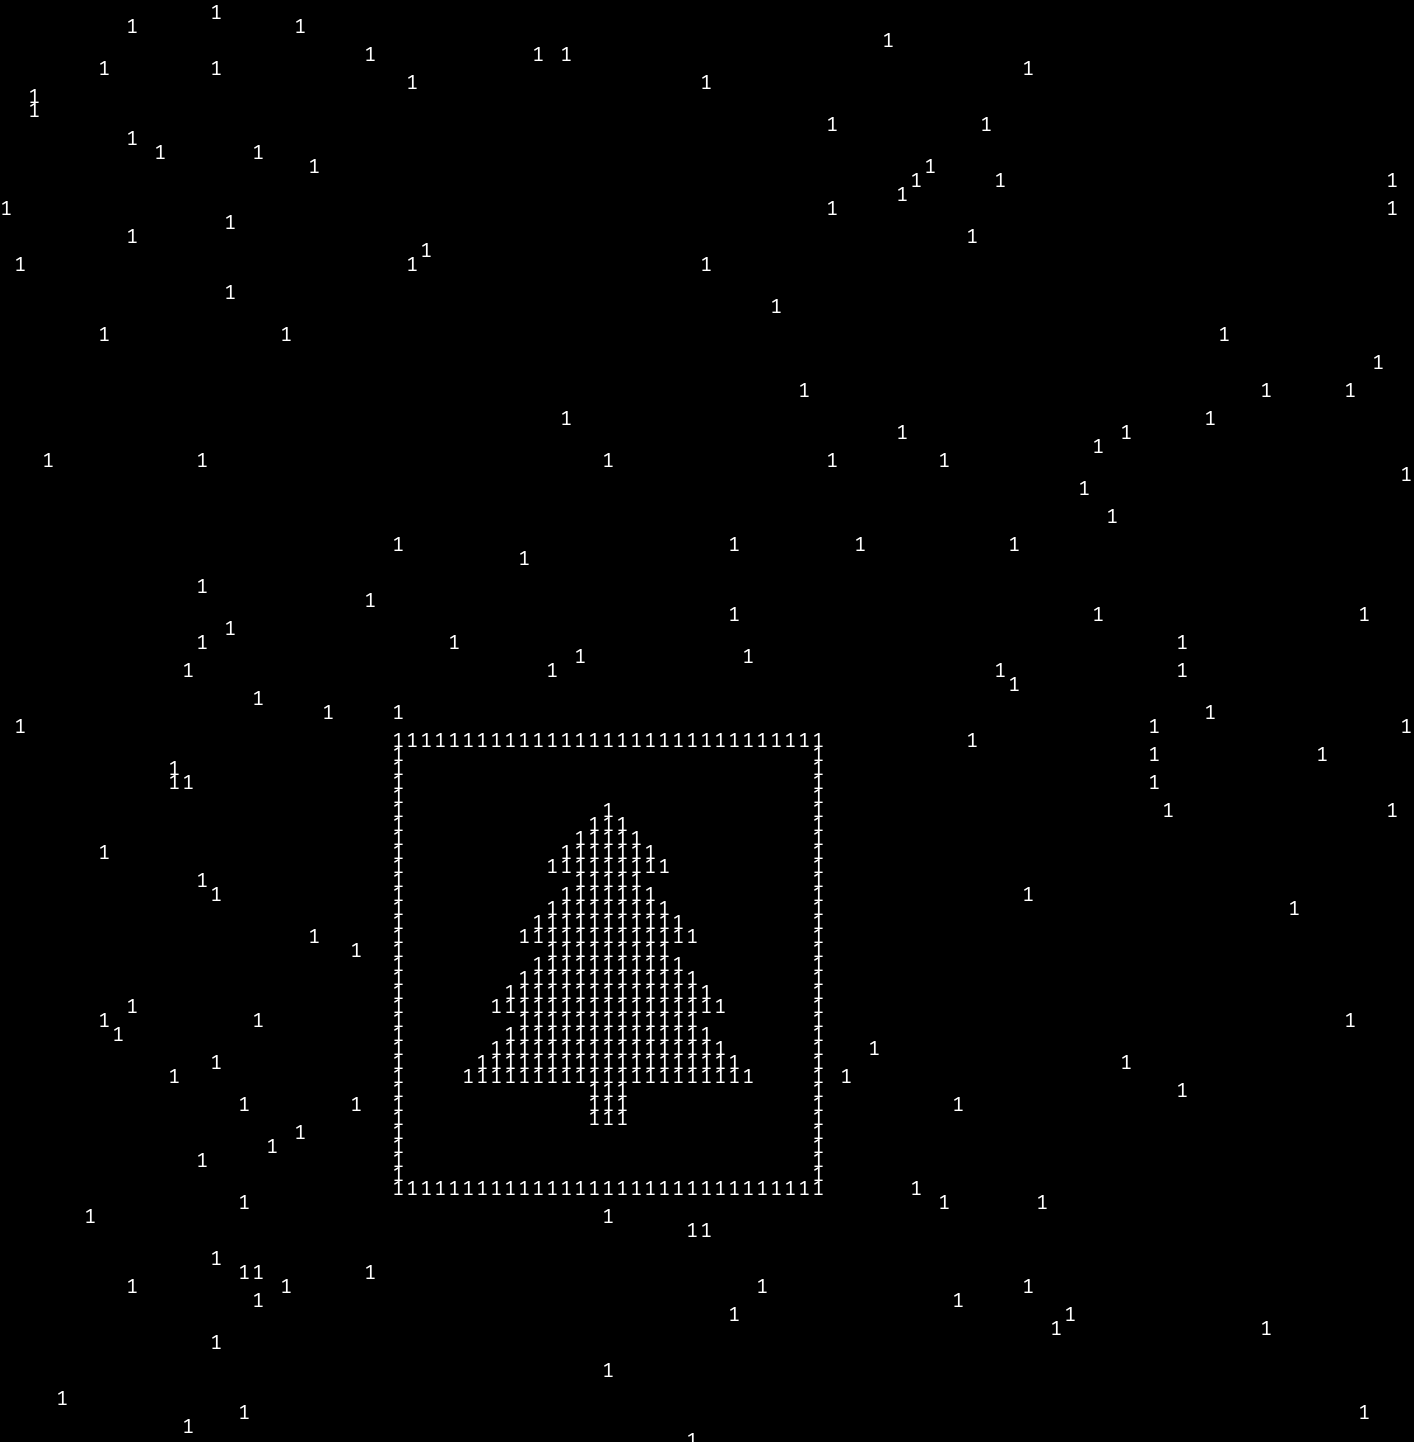

In [52]:
from PIL import Image, ImageDraw, ImageFont
from tqdm import tqdm

TOTAL_FRAMES = np.prod(dims)

font_path = "FiraCode-Regular.ttf"  # A monospace font is recommended
font_size = 20
font = ImageFont.truetype(font_path, font_size)

# Determine text size:
bbox = font.getbbox("X")  # Get bounding box of a single character
char_width, char_height = (
    bbox[2] - bbox[0],
    bbox[3] - bbox[1],
)  # Calculate width and height

char_side = max(char_height, char_width)

img_width = dims[0] * char_side
img_height = dims[1] * char_side


def make_image(time_elapsed):
    img = Image.new("RGB", (img_width, img_height), (0, 0, 0))
    draw = ImageDraw.Draw(img)

    # draw the frame count in top left in red
    # draw.text((0, 0), str(i), font=font, fill=(255, 0, 0))

    for (x, y), num in get_position_counter(robots, time_elapsed).items():
        draw.text(
            (x * char_side, y * char_side), str(num), font=font, fill=(255, 255, 255)
        )

    return img


make_image(6771)